In [1]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from os.path import join
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19 #For Transfer Learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical
import category_encoders as ce
from sklearn.preprocessing import label_binarize

In [2]:
raw_data_train = pd.read_csv('meat_train_data.csv')
raw_data_test = pd.read_csv('meat_test_data.csv')

In [3]:
raw_data_train

,Unnamed: 0,level_0,DateTimeRecorded,PlantID,ProductID,Weight,TotEOLWeightSpec1,EOLBatchStart,filename_x,filename_y
0,2,2,7/17/17 8:06,202.0,20004,1.18,25.185,6.366750e+10,camera-screenshot202200041500275215.png,background1500275180.601.png
1,3,3,7/17/17 8:07,202.0,20003,4.48,19.364,6.366750e+10,camera-screenshot202200031500275226.png,background1500275180.601.png
2,4,4,7/17/17 8:07,202.0,20004,1.08,36.614,6.366750e+10,camera-screenshot202200041500275242.png,background1500275180.601.png
3,5,5,7/17/17 8:07,202.0,20003,3.82,28.046,6.366750e+10,camera-screenshot202200031500275247.png,background1500275180.601.png
4,6,6,7/17/17 8:08,202.0,20004,1.08,48.043,6.366750e+10,camera-screenshot202200041500275315.png,background1500275357.372.png
...,...,...,...,...,...,...,...,...,...,...
6927,8664,8664,NaN,NaN,20002,7.42,NaN,NaN,augmented_image_93.png,NaN
6928,8665,8665,NaN,NaN,20002,10.80,NaN,NaN,augmented_image_94.png,NaN
6929,8666,8666,NaN,NaN,20002,8.96,NaN,NaN,augmented_image_95.png,NaN
6930,8668,8668,NaN,NaN,20002,8.58,NaN,NaN,augmented_image_97.png,NaN


In [4]:
raw_copy_train = raw_data_train[["ProductID","filename_x"]]
raw_copy_test = raw_data_test[["ProductID","filename_x"]]

In [5]:
product_names_train = raw_copy_train["filename_x"].unique()
product_names_train

array(['camera-screenshot202200041500275215.png',
       'camera-screenshot202200031500275226.png',
       'camera-screenshot202200041500275242.png', ...,
       'augmented_image_95.png', 'augmented_image_97.png',
       'augmented_image_98.png'], dtype=object)

In [6]:
product_names_test = raw_copy_test["filename_x"].unique()
product_names_test

array(['camera-screenshot202200041500275178.png',
       'camera-screenshot202200031500275183.png',
       'camera-screenshot202200041500275343.png', ...,
       'augmented_image_92.png', 'augmented_image_96.png',
       'augmented_image_99.png'], dtype=object)

In [7]:
products_train = raw_copy_train["ProductID"]
encoder=ce.OneHotEncoder(cols='ProductID',handle_unknown='return_nan',return_df=True,use_cat_names=True)

In [8]:
products_train.value_counts()

20010    2289
20003    1825
20004    1793
20001     905
20002     120
Name: ProductID, dtype: int64

In [9]:
products_test = raw_copy_test["ProductID"]
encoder = ce.OneHotEncoder(cols='ProductID',handle_unknown='return_nan',return_df=True,use_cat_names=True)

In [10]:
products_test.value_counts()

20010    574
20003    458
20004    448
20001    228
20002     31
Name: ProductID, dtype: int64

In [11]:
train_encoded = encoder.fit_transform(products_train)
train_encoded

C:\Users\Lenovo\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,ProductID_20004.0,ProductID_20003.0,ProductID_20002.0,ProductID_20001.0,ProductID_20010.0
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
6927,0.0,0.0,1.0,0.0,0.0
6928,0.0,0.0,1.0,0.0,0.0
6929,0.0,0.0,1.0,0.0,0.0
6930,0.0,0.0,1.0,0.0,0.0


In [12]:
test_encoded = encoder.fit_transform(products_test)
test_encoded

C:\Users\Lenovo\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,ProductID_20004.0,ProductID_20003.0,ProductID_20002.0,ProductID_20001.0,ProductID_20010.0
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1734,0.0,0.0,1.0,0.0,0.0
1735,0.0,0.0,1.0,0.0,0.0
1736,0.0,0.0,1.0,0.0,0.0
1737,0.0,0.0,1.0,0.0,0.0


In [13]:
def read_img(img_id, train, size):
   
    img = image.load_img(join("OneDrive/output_datasets/shrink_train_test_data" , train, '%s' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [14]:
IMG_SIZE = 56

X_all = np.zeros((len(raw_copy_train), IMG_SIZE, IMG_SIZE, 3), dtype='float32')
Y_all = label_binarize(raw_copy_train["ProductID"], classes = product_names_train)

for i in tqdm(range(len(raw_copy_train))):
    img = read_img(raw_copy_train['filename_x'][i],'train', (IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(img.copy(), axis=0)
    X_all[i] = x / 255.0
    
print('Training Images Shape: {} size: {:,}'.format(X_all.shape, X_all.size))

C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 6932/6932 [00:14<00:00, 483.81it/s]

Training Images Shape: (6932, 56, 56, 3) size: 65,216,256


In [15]:
def read_img(img_id, test, size):
   
    img = image.load_img(join("OneDrive/output_datasets/shrink_train_test_data" , test, '%s' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [16]:
IMG_SIZE = 56

A_all = np.zeros((len(raw_copy_test), IMG_SIZE, IMG_SIZE, 3), dtype='float32')
B_all = label_binarize(raw_copy_test["ProductID"], classes = product_names_test)

for i in tqdm(range(len(raw_copy_test))):
    img = read_img(raw_copy_test['filename_x'][i],'test', (IMG_SIZE, IMG_SIZE))
    a = np.expand_dims(img.copy(), axis=0)
    A_all[i] = a / 255.0
    
print('Test Images Shape: {} size: {:,}'.format(A_all.shape, A_all.size))

C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 1739/1739 [00:03<00:00, 482.78it/s]

Test Images Shape: (1739, 56, 56, 3) size: 16,360,512


In [17]:
X_all.shape

(6932, 56, 56, 3)

In [18]:
A_all.shape

(1739, 56, 56, 3)

In [19]:
train_encoded.shape

(6932, 5)

In [20]:
test_encoded.shape

(1739, 5)

In [21]:
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

In [22]:
vgg_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (56,56,3), classes = train_encoded.shape[1])

In [23]:
model= Sequential()
model.add(vgg_model) 
model.add(Flatten()) 

In [24]:
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dense(128,activation=('relu')))
model.add(Dense(5,activation=('softmax'))) 


In [25]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 6

In [26]:
batch_size= 100
epochs=5
learning_rate=.001
sgd=SGD(lr=learning_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [27]:
tf.config.run_functions_eagerly(True)

In [28]:
vgg_model = model.fit(X_all, train_encoded, batch_size=batch_size, epochs=epochs, verbose=1, callbacks =[lrr],
                      validation_data=(A_all, test_encoded))

C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 1/5
70/70 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.7986

C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


70/70 [==============================] - 551s 8s/step - loss: 0.5674 - accuracy: 0.7986 - val_loss: 0.2709 - val_accuracy: 0.9080
Epoch 2/5
70/70 [==============================] - 572s 8s/step - loss: 0.1411 - accuracy: 0.9523 - val_loss: 0.1033 - val_accuracy: 0.9666
Epoch 3/5
70/70 [==============================] - 570s 8s/step - loss: 0.1008 - accuracy: 0.9706 - val_loss: 0.1137 - val_accuracy: 0.9638
Epoch 4/5
70/70 [==============================] - 582s 8s/step - loss: 0.0905 - accuracy: 0.9713 - val_loss: 0.1311 - val_accuracy: 0.9534
Epoch 5/5
70/70 [==============================] - 584s 8s/step - loss: 0.0728 - accuracy: 0.9779 - val_loss: 0.0626 - val_accuracy: 0.9862


In [29]:
predicted_images = model.predict_classes(A_all)


C:\Users\Lenovo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [30]:
trained_images = model.predict_classes(X_all)

In [31]:
trained_images 

array([0, 1, 0, ..., 2, 2, 2], dtype=int64)

In [32]:
vgg_training = pd.DataFrame(trained_images, columns =["ProductID"])

In [33]:
vgg_training.value_counts()

ProductID
4            2280
1            1838
0            1794
3             902
2             118
dtype: int64

In [35]:
original_train_data = raw_copy_train[['ProductID']]

In [36]:
train_data = original_train_data.replace({'ProductID':{20001:3, 20002:2, 20003:1, 20004:0, 20010:4 }})

In [37]:
train_data

,ProductID
0,0
1,1
2,0
3,1
4,0
...,...
6927,2
6928,2
6929,2
6930,2


In [38]:
#train Data Metrics 
from sklearn import metrics

print(metrics.classification_report(trained_images, train_data))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1794
           1       0.99      0.98      0.98      1838
           2       0.95      0.97      0.96       118
           3       0.97      0.97      0.97       902
           4       0.99      1.00      0.99      2280

    accuracy                           0.99      6932
   macro avg       0.98      0.98      0.98      6932
weighted avg       0.99      0.99      0.99      6932



In [32]:
predicted_images

array([0, 1, 0, ..., 2, 4, 2], dtype=int64)

In [63]:
vgg_predictions = pd.DataFrame(predicted_images, columns = ["ProductID"])

In [64]:
vgg_predictions.value_counts()

ProductID
4            572
1            460
0            449
3            228
2             30
dtype: int64

In [65]:
original_test_data = raw_copy_test[['ProductID']]

In [66]:
test_data = original_test_data.replace({'ProductID':{20001:3, 20002:2, 20003:1, 20004:0, 20010:4 }})

In [75]:
test_data

,ProductID
0,0
1,1
2,0
3,1
4,0
...,...
1734,2
1735,2
1736,2
1737,2


In [74]:
#test Data Metrics
from sklearn import metrics

# Print the precision and recall, among other metrics
print(metrics.classification_report(predicted_images, test_data))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       449
           1       0.98      0.98      0.98       460
           2       0.94      0.97      0.95        30
           3       0.97      0.97      0.97       228
           4       0.99      0.99      0.99       572

    accuracy                           0.99      1739
   macro avg       0.97      0.98      0.98      1739
weighted avg       0.99      0.99      0.99      1739



In [ ]:
# 0 - 20004
# 1 - 20003
# 2 - 20002
# 3 - 20001
# 4 - 20010

In [72]:
def plot_confusion_matrix( confusion_mtx , classesx, classesy,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(test_data, predicted_images)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classesx, yticklabels=classesy,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [70]:
confusion_mtx = confusion_matrix(test_data, predicted_images)

In [43]:
confusion_mtx

array([[1792,    1,    0,    0,    0],
       [   1, 1803,    0,   19,    2],
       [   0,    0,  114,    0,    6],
       [   1,   25,    0,  876,    3],
       [   0,    9,    4,    7, 2269]], dtype=int64)

In [67]:
from sklearn.metrics import *
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(predicted_images, test_data)
print('Accuracy: %f' % accuracy)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(predicted_images, test_data , pos_label='positive',
                                           average='micro')
precision = precision_score(predicted_images, test_data,pos_label='positive',
                                           average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(predicted_images, test_data,pos_label='positive',
                                           average='micro')
print('F1 score: %f' % f1)
print('Recall Score : %f' % recall)

Accuracy: 0.986199
Precision: 0.986199
F1 score: 0.986199
Recall Score : 0.986199


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [68]:
from sklearn.metrics import *
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trained_images, train_data)
print('Accuracy: %f' % accuracy)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(trained_images, train_data , pos_label='positive',
                                           average='micro')
precision = precision_score(trained_images, train_data,pos_label='positive',
                                           average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(trained_images, train_data,pos_label='positive',
                                           average='micro')
print('F1 score: %f' % f1)
print('Recall Score : %f' % recall)

Accuracy: 0.988748
Precision: 0.988748
F1 score: 0.988748
Recall Score : 0.988748


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1295: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [69]:
class_namesx= ['20004','20003','20002','20001','20010']
class_namesy= ['20004','20003','20002','20001', '20010']

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, image count'}, xlabel='Predicted label', ylabel='True label'>

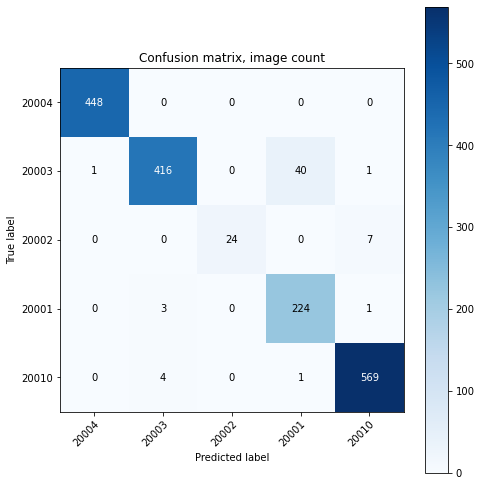

In [88]:
plot_confusion_matrix(confusion_mtx , classesx = class_namesy, classesy = class_namesx, title='Confusion matrix, image count')

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, image count'}, xlabel='Predicted label', ylabel='True label'>

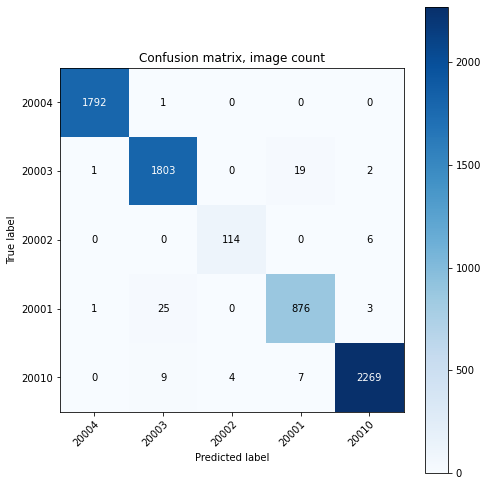

In [53]:
plot_confusion_matrix(confusion_mtx , classesx = class_namesy, classesy = class_namesx, title='Confusion matrix, image count')

Normalized confusion matrix


<AxesSubplot:title={'center':'Confusion matrix, percentages'}, xlabel='Predicted label', ylabel='True label'>

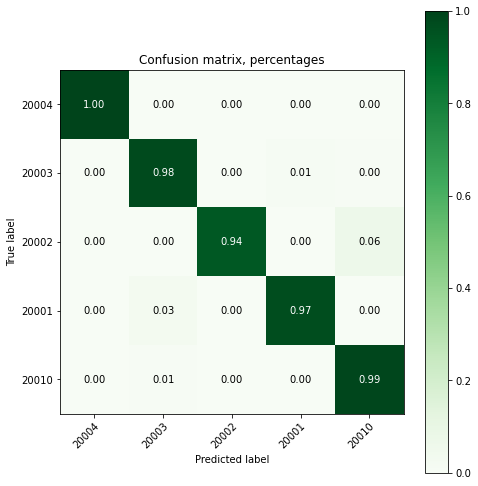

In [73]:
plot_confusion_matrix(confusion_mtx , classesx = class_namesy, classesy = class_namesx,normalize=True, title='Confusion matrix, percentages')

Normalized confusion matrix


<AxesSubplot:title={'center':'Confusion Matrix for Training Data in VGG19 Net'}, xlabel='Predicted label', ylabel='True label'>

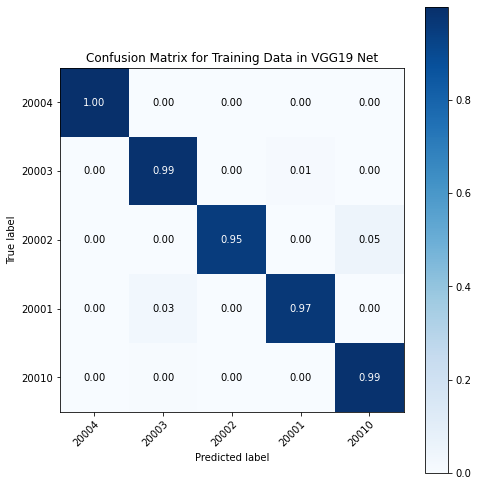

In [60]:
plot_confusion_matrix(confusion_mtx , classesx = class_namesy, classesy = class_namesx,normalize=True, title='Confusion Matrix for Training Data in VGG19 Net')